# Ham Sandwich Tree

El Ham Sandwich Tree es una estructura de datos que tiene como objetivo dividir a la mitad un conjunto de datos de manera recursiva y eficiente un conjunto de puntos en el espacio n-dimensional. Esta deriva del Ham Sandwich Theorem, por lo que es bastante importante entenderlo primeramente.

## Ham Sandwich Theorem
El teorema del pan con jamón dice que teniendo n objetos en el espacio n-dimensional, existe un único hiperplano n-1 dimensional que corta simultáneamente todos estos n objetos en dos partes de igual volumen (o medida). El nombre deriva del caso n = 3, en el que si tienes dos pedazos de pan y uno de jamón en un espacio tridimensional entonces existe un único plano que corta cada uno de los tres objetos en dos particiones de igual volumen.

Este teorema cuando trabajas con puntos en vez de volúmenes te dice que siempre hay una partición en la cual divides los puntos en el espacio en cantidades iguales.

### Demostración n = 2 (El teorema del pancake)

Se procede a hacer una demostración para el caso específico n = 2: $\newline$

**Enunciado**

Sean dos regiones finitas disjuntas a dividir $K_1$ y $K_2$ en el plano $\mathbb{R}^2$,
entonces existe una recta $L \subset \mathbb{R}^2$ que divide simultaneamente a ambos conjuntos en dos partes de igual área.


**Demostración**

Sea el círculo $S^1 = \{(x,y) \in \mathbb{R}^2 : x^2 + y^2 = 1\}$, cada dirección en un plano tiene un vector unitario correspondiente, este puede ser pensado como un punto en el círculo $S^1$. 

Para cada dirección $m = (\cos(\theta), \sin(\theta)) \in S^1$, hay una única línea l(m) con pendiente $\tan(\theta)$ que divide la región $K_1$ en partes igual área. ...(1)

Además, la línea l(m) divide $K_2$ en dos regiones, vamos a llamar a una de ella la parte positiva $P(m)$ y a la otra la parte negativa $N(m)$. Luego definimos una función $f: S^1 \to \mathbb{R}$ tal que

$$f(m) := Área(K_2 \cap P(m))$$

Es decir, $f(m)$ es el área contenida en la parte positiva de $l(m)$. 

Dado que $f(m)$ es una función continua, se puede usar el teorema de Borsuk-Ulman. Este teorema afirma que si $f: S^n \to \mathbb{R}^n$ es continua, entonces existe $x \in S^n$ tal que: $f(-x) = f(x)$

Nótese que $f(-n)$ es precisamente $Área(K_2 \cap N(n))$ dado que el lado positivo $l(-n)$ is precisamente el lado negativo de $l(n)$. Entonces, $Área(K_2 \cap P(n)) = Área(K_2 \cap N(n))$. Esto significa que $l(n)$ bisecta $K_2$. Según (1) $l(m)$ biseca $K_1$ para todo $m \in S^1$. Entonces la línea $l(n)$ biseca a $K_1$ y a $K_2$ a la vez.

## Implementacion

Según la información investigada, el algoritmo generalmente usado para resolver el Ham Sandwich Theorem es el implementado por Lo, Matousek y Steiger de 1994 rescatada del artículo: https://linux.ime.usp.br/~kobus/mac0499/monografia.pdf

Dicha implementación usa la dualidad de punto-recta para poder encontrar el punto y la dirección exacta que parte al conjunto en dos con una complejidad de $\mathcal{O}(n\log(n))$

Sin embargo, para una cantidad de datos muy grande en un espacio reducido 
($n > 250$ y $b < 10$, siendo $b$ el lado del cubo que contiene todos los puntos) se puede usar una heurística que consiste en escoger aleatoriamente una direción $d$, luego ordenar los puntos en una lista segun el producto interno de esa dirección y la posición de cada punto en el espacio. 

Entonces la aproximación de la recta deseada tendrá como direción a la ortogonal de $d$ y pasará por el punto medio de la lista ordenada



## Error de bisección

El error en la bisección se define como la diferencia entre el número de puntos en cada lado del corte:

$$
\epsilon = \left| \# \{ i : \vec{p}_i \cdot \vec{d} < m \} - \# \{ i : \vec{p}_i \cdot \vec{d} > m \} \right|
$$

En el caso de $ n $ impar, este error siempre es al menos 1, ya que la mediana deja un punto exactamente sobre la línea. Para $ n $ par, puede ser cero.

Si el conjunto está uniformemente distribuido, entonces en promedio:

$$
\mathbb{E}[\epsilon] \approx 0
$$

Pero si hay sesgo direccional o agrupamiento, el error aumenta.

## Probabilidad de fallo

La probabilidad de que una dirección aleatoria no genere una bisección razonablemente equilibrada depende del grado de agrupamiento del conjunto. Sea $ \theta $ el ángulo de la dirección aleatoria respecto a la dirección de máxima varianza del conjunto.

Suponiendo distribución uniforme:

La probabilidad de que una dirección **aleatoria** produzca una bisección con error $ \epsilon \geq k $ decrece **exponencialmente** con $ k $:

$$
P(\epsilon \geq k) \leq 2e^{-2k^2/n}
$$

(Esta cota proviene de una versión del límite de Hoeffding aplicado a la selección de medianas en proyecciones.)


## Implicación práctica

Esto implica que:

- Una sola proyección aleatoria tiene alta probabilidad de ser una bisección "suficientemente buena".
- Si queremos garantizar que el error sea menor que $ \epsilon $, podemos repetir el muestreo $ O(\log(1/\delta)) $ veces para alcanzar una probabilidad de fallo $ \delta $ arbitrariamente pequeña.

Por ejemplo, si queremos que:

$$
P(\text{error} > k) < 0.01
$$

Basta repetir la selección de dirección aleatoria y quedarnos con la mejor de las $ \approx \log_2(1/0.01) \approx 7 $ direcciones.

## Análisis de complejidad del algoritmo del Árbol de Sándwich de Jamón (2D)

### Descripción del algoritmo

Para construir un árbol de sándwich de jamón sobre un conjunto de $ n $ puntos en 2D:

1. Se elige una dirección aleatoria $ \vec{d} \in S^1 $.
2. Se proyectan todos los puntos sobre $ \vec{d} $, obteniendo un conjunto de valores escalares.
3. Se ordenan las proyecciones para encontrar la mediana.
4. Se divide el conjunto en dos subconjuntos con respecto a la línea $ \vec{x} \cdot \vec{d} = m $, donde $ m $ es la mediana proyectada.
5. Se repite recursivamente el proceso en cada subconjunto hasta que haya pocos puntos (caso base).



### Complejidad por nivel de recursión

Para cada paso:

- Proyección de todos los puntos:  
  $$
  O(n)
  $$
- Ordenar proyecciones para hallar la mediana:  
  $$
  O(n \log n)
  $$

- División en dos subconjuntos:  
  $$
  O(n)
  $$

Costo total por nivel de recursión:

$$
T(n) = O(n \log n)
$$



### Profundidad del árbol

Dado que cada línea de corte divide (aproximadamente) a la mitad el conjunto de puntos, el árbol tendrá una profundidad de:

$$
\log_2 n
$$



### Repeticiones por precisión

Si repetimos el muestreo de direcciones aleatorias $ r $ veces por nivel para reducir la probabilidad de error de bisección (por ejemplo, eligiendo la mejor entre $ r $ líneas candidatas), entonces el costo por nivel se multiplica por $ r $:

$$
T_{\text{repetido}}(n) = O(r \cdot n \log n)
$$

En la práctica, $ r $ es una constante baja (5 a 10), por lo que no cambia la clase de complejidad.



### Complejidad total

Dado que el árbol tiene $ \log_2 n $ niveles y el costo por nivel es $ O(n \log n) $, la complejidad total es:

$$
T_{\text{total}}(n) = O(n \log n \log n) = O(n \log^2 n)
$$



### Complejidad de consultas

Una vez construido el árbol, se pueden realizar consultas de pertenencia a una región poligonal convexa:

- Cada punto pasa por un camino de profundidad $ O(\log n) $.
- Si el polígono tiene $ k $ lados, se evalúa la pertenencia con respecto a $ k $ medias-espacios.
- Por tanto, la complejidad de la búsqueda de puntos dentro de un polígono convexo es:

$$
O(k \cdot \log n + m)
$$

donde $ m $ es el número de puntos reportados.



### Conclusión

| Etapa                        | Complejidad                 |
|--|--|
| Construcción del árbol      | $ O(n \log^2 n) $         |
| Consulta (polígono convexo) | $ O(k \log n + m) $       |
| Profundidad del árbol       | $ O(\log n) $             |

Esto hace al árbol de sándwich de jamón adecuado para búsquedas de rango con regiones no alineadas con los ejes, en comparación con estructuras como kd-trees o quadtrees.



### Nota

Existe una implementación que sí puede dar el punto exacto y la dirección de bisección con complejidad 
$\mathcal{O}(n)$ por nivel del arbol, sin embargo no contamos con el conocimiento matemático suficiente para poder explicar el funcionamiento de dicha implementación. Se puede encontrar en el artículo: https://linux.ime.usp.br/~kobus/mac0499/monografia.pdf

# HSTNode class

In [9]:
from typing import List, Optional
import numpy as np

class HSTNode:
	"""
	Representa un nodo en un Ham Sandwich Tree (HST), que almacena un subconjunto de puntos
	del espacio junto con la información de corte usada para dividirlos.

	Atributos:
	-
	root : Optional[HSTNode]
		Referencia al nodo raíz del árbol (para acceso global si es necesario).
	
	height : int
		Altura del nodo dentro del árbol (profundidad desde la raíz).
	
	points : List[np.ndarray]
		Lista de puntos asignados a este nodo.
	
	medianProj : float
		Valor de la proyección del punto mediano a lo largo de la dirección de corte.
		(Se debe asignar externamente durante la división).
	
	direction : np.ndarray
		Vector de dirección (2D o 3D) usado para dividir los puntos en este nodo.
	
	medianPoint : np.ndarray
		Punto espacial correspondiente a la mediana proyectada, usado como referencia de corte.
	
	parent : Optional[HSTNode]
		Referencia al nodo padre en el árbol, si existe.
	
	left : Optional[HSTNode]
		Nodo hijo izquierdo (contiene los puntos con proyección menor a la mediana).
	
	right : Optional[HSTNode]
		Nodo hijo derecho (contiene los puntos con proyección mayor o igual a la mediana).
	"""
	
	def __init__(self):
		self.root: Optional['HSTNode'] = None
		self.height: int = 0.0

		self.points: List[np.ndarray] = []  

		self.medianProj: float
		self.direction: np.ndarray = np.zeros(3)  
		self.medianPoint: np.ndarray = np.zeros(3)

		self.parent: Optional['HSTNode'] = None

		self.left: Optional['HSTNode'] = None
		self.right: Optional['HSTNode'] = None




# HST class

In [ ]:
from typing import List, Optional
import numpy as np
import random
import math


class HamSandwichTree:
	"""
	Representa un árbol de tipo 'Ham Sandwich Tree', que divide recursivamente un conjunto de puntos
	en 2D o 3D usando cortes balanceados en direcciones aleatorias.
	"""

	def __init__(self, is3D: bool, quantity: int = 100, boundary: float = 10):
		"""
		Inicializa el árbol con los parámetros dados.

		Parámetros:
		--
		is3D : bool
			Si es True, se generarán puntos en 3D. Si es False, serán en 2D.
		quantity : int
			Número de puntos a generar al iniciar el árbol.
		boundary : float
			Límite máximo (en valor absoluto) para las coordenadas de los puntos.
		"""
		self.is3D = is3D    
		self.quantity = quantity
		self.boundary = boundary
		self.points: List[np.ndarray] = [] 
		self.root: Optional[HSTNode] = None
		self.Start() 
	#main

	def Start(self):
		"""
		Método principal para iniciar la construcción del árbol.
		Genera puntos aleatorios y crea el árbol a partir de ellos.
		"""
		random.seed()
		self.SpawnRandomPoints(self.quantity, self.boundary)
		self.CreateTree()

	def CreateTree(self):
		"""
		Inicializa el nodo raíz del árbol con todos los puntos generados
		y llama al proceso recursivo para construir el árbol completo.
		"""
		self.root = self.CreateNode()
		self.root.points = self.points
		self.CreateTreeAux(self.root)

	def CreateTreeAux(self, node: HSTNode):
		"""
		Construcción recursiva del árbol. Detiene la recursión si el nodo tiene menos de 5 puntos.

		Parámetros:
		--
		node : HSTNode
			Nodo actual a subdividir recursivamente.
		"""
		if len(node.points) < 5:
			return
		self.SplitPoints(node)
		self.CreateTreeAux(node.left)
		self.CreateTreeAux(node.right)

	def CreateNode(self, parent: Optional[HSTNode] = None) -> HSTNode:
		"""
		Crea un nuevo nodo del árbol, conectándolo a su padre si se proporciona.

		Parámetros:
		--
		parent : Optional[HSTNode]
			Nodo padre del nuevo nodo (si existe).

		Retorna:
		--
		HSTNode
			Nodo recién creado.
		"""
		newNode = HSTNode()
		newNode.root = self.root
		newNode.parent = parent
		if parent is not None:
			newNode.height = parent.height + 1
		return newNode

	def SpawnRandomPoints(self, quantity: int, boundary: float):
		"""
		Genera puntos aleatorios dentro de los límites dados. Si `is3D` es False, los puntos serán en 2D.

		Parámetros:
		--
		quantity : int
			Número total de puntos a generar.
		boundary : float
			Límite absoluto en cada eje para las coordenadas de los puntos.
		"""
		for i in range(quantity):
			x = random.uniform(-boundary, boundary)
			y = random.uniform(-boundary, boundary)
			z = 0.0
			if self.is3D:
				z = random.uniform(-boundary, boundary)
				
			pos = np.array([x, y, z], dtype=float)
			self.points.append(pos)

	# HAM SANDWICH ALGORITHM 
	def SplitPoints(self, node: HSTNode):
		"""
		Aplica el algoritmo de corte Ham Sandwich para dividir los puntos del nodo en dos subconjuntos,
		usando una dirección aleatoria.

		Parámetros:
		--
		node : HSTNode
			Nodo actual cuyos puntos serán divididos en dos mitades.
		"""
		theta = random.uniform(0, math.pi)
		phi = random.uniform(0, math.pi)

		if self.is3D:
			direction = np.array([
				math.cos(theta) * math.sin(phi),
				math.sin(theta) * math.sin(phi),
				math.cos(phi)
			], dtype=float)
		else:
			direction = np.array([
				math.cos(theta),
				math.sin(theta),
				0.0
			], dtype=float)

		projections = [{'point': p, 'projection': np.dot(p, direction)} for p in node.points]
		projections.sort(key=lambda e: e['projection'])

		median_index = len(projections) // 2
		medianPoint = projections[median_index]['point']
		medianProj = projections[median_index]['projection']

		rightPoints: List[np.ndarray] = []
		leftPoints: List[np.ndarray] = []

		for element in projections:
			if element['projection'] >= medianProj:
				rightPoints.append(element['point'])
			else:
				leftPoints.append(element['point'])

		node.left = self.CreateNode(node)
		node.right = self.CreateNode(node)
		node.left.points = leftPoints
		node.right.points = rightPoints
		node.direction = direction
		node.medianPoint = medianPoint
		node.medianProj = medianProj





# Profiling


test_profile_create_tree_method (__main__.HSTProfile.test_profile_create_tree_method) ... ok
test_profile_split_method (__main__.HSTProfile.test_profile_split_method) ... ok

----------------------------------------------------------------------
Ran 2 tests in 47.550s

OK


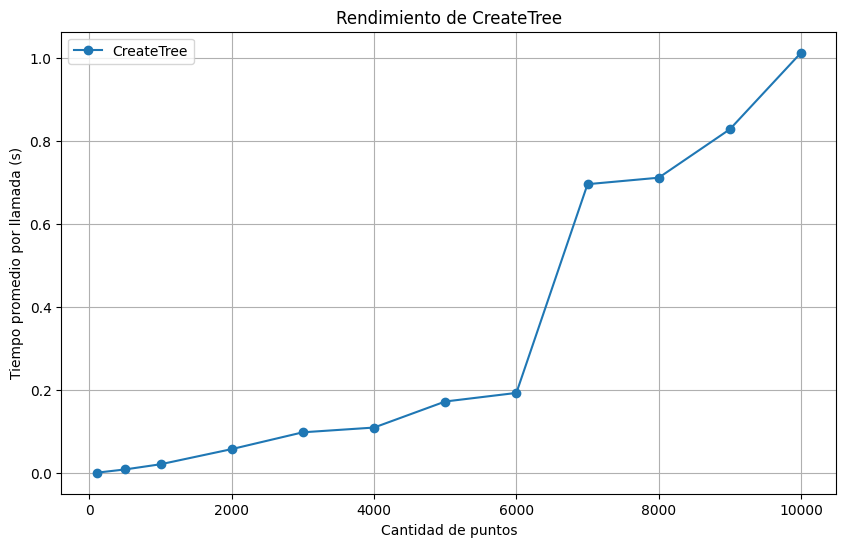

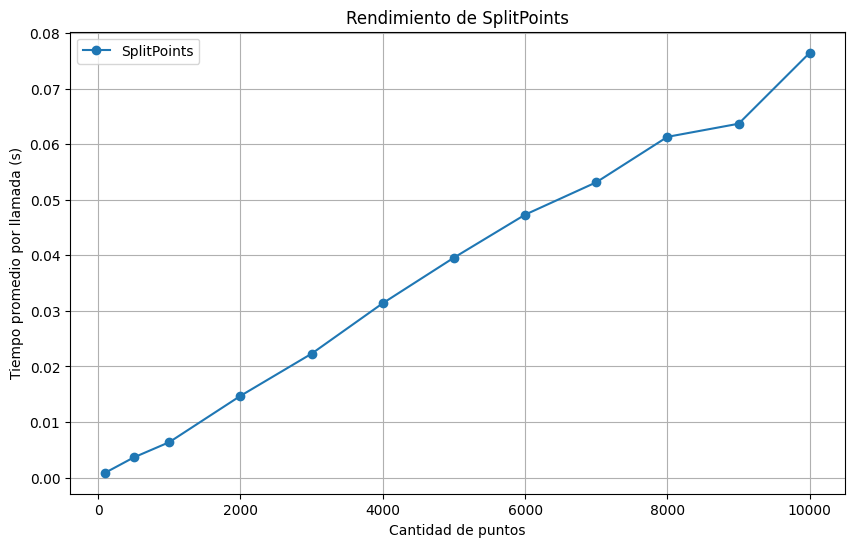

In [26]:
import cProfile
import pstats
import random
import unittest
from typing import List, Tuple
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

if not os.path.exists('data'):
    os.makedirs('data', exist_ok=True)


class HSTProfile(unittest.TestCase):
    Quantities = [100, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
    Runs = 10  
    OutputFileName = 'data/stats_hst.csv'
    OutputFileNameSplit = 'data/stats_hst_split.csv'

    @staticmethod
    def write_header(f) -> None:
        f.write('test_case,quantity,method_name,total_time,cumulative_time,per_call_time\n')

    @staticmethod
    def write_row(f, test_case: str, quantity: int, method_name: str, total_time: float,
                   cumulative_time: float, per_call_time: float) -> None:
        f.write(f'{test_case},{quantity},{method_name},{total_time},{cumulative_time},{per_call_time}\n')

    @staticmethod
    def get_running_times(st: pstats.Stats, method_name: str) -> List[Tuple[str, float, float, float]]:
        ps = st.strip_dirs().stats

        def is_method(k):
            return method_name in k[2]

        keys = list(filter(is_method, ps.keys()))
        return [(key[2], ps[key][2], ps[key][3], ps[key][3] / ps[key][1]) for key in keys]

    def test_profile_create_tree_method(self) -> None:
        with open(HSTProfile.OutputFileName, 'w') as f:
            HSTProfile.write_header(f)
            for qty in HSTProfile.Quantities:
                for _ in range(HSTProfile.Runs):
                    tree = HamSandwichTree(is3D=True, quantity=qty, boundary=10)
                    tree.SpawnRandomPoints(tree.quantity, tree.boundary)  
                    pro = cProfile.Profile()
                    pro.runcall(tree.CreateTree)  
                    st = pstats.Stats(pro)

                    for method_name, total_time, cumulative_time, per_call_time in \
                            HSTProfile.get_running_times(st, 'CreateTree'):
                        HSTProfile.write_row(f, 'HST', qty, method_name, total_time, cumulative_time, per_call_time)

                    for method_name, total_time, cumulative_time, per_call_time in \
                            HSTProfile.get_running_times(st, 'CreateTreeAux'):
                        HSTProfile.write_row(f, 'HST', qty, method_name, total_time, cumulative_time, per_call_time)

    def test_profile_split_method(self) -> None:
        with open(HSTProfile.OutputFileNameSplit, 'w') as f:
            HSTProfile.write_header(f)
            for qty in HSTProfile.Quantities:
                for _ in range(HSTProfile.Runs):
                    tree = HamSandwichTree(is3D=True, quantity=qty, boundary=10)
                    tree.SpawnRandomPoints(tree.quantity, tree.boundary)
                    root = tree.CreateNode()
                    root.points = tree.points
                    pro = cProfile.Profile()
                    pro.runcall(tree.SplitPoints, root)
                    st = pstats.Stats(pro)

                    for method_name, total_time, cumulative_time, per_call_time in \
                            HSTProfile.get_running_times(st, 'SplitPoints'):
                        HSTProfile.write_row(f, 'HST', qty, method_name, total_time, cumulative_time, per_call_time)


def plot_profile_results(csv_file: str, title: str, only_create_tree: bool = False):
    df = pd.read_csv(csv_file)

    if only_create_tree:
        df = df[df['method_name'] == 'CreateTree']

    grouped = df.groupby(['quantity', 'method_name']).agg({
        'per_call_time': 'mean'
    }).reset_index()

    plt.figure(figsize=(10, 6))
    for method in grouped['method_name'].unique():
        method_data = grouped[grouped['method_name'] == method]
        plt.plot(method_data['quantity'], method_data['per_call_time'],
                 marker='o', label=method)

    plt.title(title)
    plt.xlabel('Cantidad de puntos')
    plt.ylabel('Tiempo promedio por llamada (s)')
    plt.legend()
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    suite = unittest.TestLoader().loadTestsFromTestCase(HSTProfile)
    unittest.TextTestRunner(verbosity=2).run(suite)

    plot_profile_results('data/stats_hst.csv', 'Rendimiento de CreateTree', only_create_tree=True)
    plot_profile_results('data/stats_hst_split.csv', 'Rendimiento de SplitPoints', only_create_tree=False)




# Verificación de un punto en un polígono convexo

Para esto se usaron dos algoritmos, ambos usan el mismo método.

### Concepto clave
Se va a repetir el siguiente proceso para todas las aristas:

* Se toma como vector a la arista.
* Se toma como vector desde el punto inicial de la arista a el punto a verificar. Llamémoslo $p$
* Se obtiene el componente z del producto cruz entre estos dos vectores.

Si el signo de todos estos resultados son iguales, entonces el punto está dentro del polígono.

### ¿Por qué esto funciona?
El producto cruzado se obtiene de la siguiente manera:

$$ 
\begin{vmatrix}
\mathbf{i} & \mathbf{j} & \mathbf{k} \\
u_x & u_y & 0 \\
v_x & v_y & 0
\end{vmatrix} = (u_x v_y - u_y v_x) \mathbf{k}
$$

Ahora, por la regla de la mano derecha, el signo de este resultado indica el lado en el que esté el punto $p$. 

La verificación se basa en que, para un polígono convexo cerrado y correctamente orientado (por ejemplo, en sentido horario), el punto no puede encontrarse a la derecha de una arista y a la izquierda de otra. Por lo tanto, la consistencia de los signos asegura que el punto está en el interior.

### Verificación de convexidad

Para verificar si un polígono es convexo usamos el mismo principio, pero en este caso los vectores involucrados serían dos aristas consecutivas. El signo de estos productos cruzados indica si las aristas mantienen la misma orientación (convexidad) o si existe un cambio de dirección (concavidad). Esto se evidencia en la siguiente imagen:

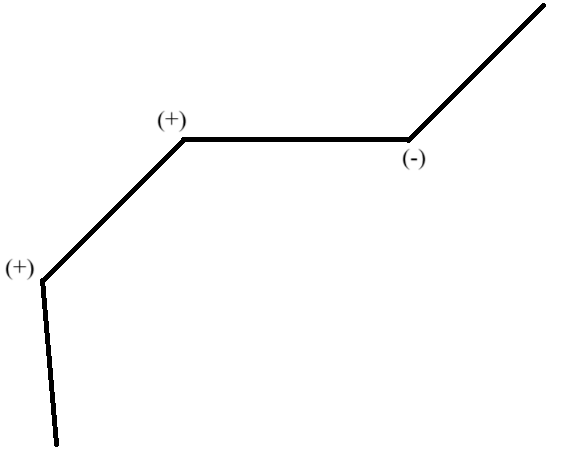

Se observa claramente que un cambio en el signo del producto cruzado implica que una arista gira hacia el lado opuesto con respecto a la orientación de la arista anterior.



# Polygon class

In [ ]:
class Polygon:
    """
    Representa un polígono en 2D definido por sus vértices.
    
    Atributos:
    - vertices: List[np.ndarray]
        Lista de vértices como vectores 2D (numpy arrays).
    """

    def __init__(self, vertices: List[np.ndarray]):
        self.vertices: List[np.ndarray] = vertices

    def contains_point(self, point: np.ndarray) -> bool:
        """
        Verifica si el punto `point` está dentro del polígono
        usando el método del producto cruz.

        Parámetros:
        - point: np.ndarray
            Punto a verificar si está en el polígono.

        Retorna:
        - bool: True si el punto está dentro o en el borde, False en caso contrario.
        """
        n = len(self.vertices)
        last_cross = 0.0

        for i in range(n):
            a = self.vertices[i]
            b = self.vertices[(i + 1) % n]
            edge = b - a
            to_point = point - a

            cross = edge[0] * to_point[1] - edge[1] * to_point[0]

            if i == 0:
                last_cross = cross
            elif cross * last_cross < 0:
                return False

        return True

    def is_convex(self) -> bool:
        """
        Verifica si el polígono es convexo.

        Retorno:
        - bool: True si es convexo, False si no lo es.
        """
        n = len(self.vertices)
        if n < 3:
            return False 

        last_cross = 0.0

        for i in range(n):
            a = self.vertices[i]
            b = self.vertices[(i + 1) % n]
            c = self.vertices[(i + 2) % n]

            ab = b - a
            bc = c - b

            cross = ab[0] * bc[1] - ab[1] * bc[0]

            if i == 0:
                last_cross = cross
            elif cross * last_cross < 0:
                return False

        return True
